#  Import Libraries

In [ ]:
!pip install tslearn -q

In [ ]:
!pip install dtaidistance -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tslearn.metrics import dtw
from scipy.linalg import eigh
from dtaidistance import dtw_ndim
import numpy as np
import os

C:\Users\Parth\AppData\Roaming\Python\Python310\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


# Load and Prepare UCI HAR Dataset

In [3]:
# Load and preprocess data
def load_data(data_path, subset_size=500):
    sensors = ['body_acc_x', 'body_acc_y', 'body_acc_z',
               'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
               'total_acc_x', 'total_acc_y', 'total_acc_z']
    X, y = [], []
    for s in sensors:
        train = np.loadtxt(os.path.join(data_path, 'train', 'Inertial Signals', f'{s}_train.txt'))
        test = np.loadtxt(os.path.join(data_path, 'test', 'Inertial Signals', f'{s}_test.txt'))
        X.append(np.vstack([train, test]))
    y_train = np.loadtxt(os.path.join(data_path, 'train', 'y_train.txt'))
    y_test = np.loadtxt(os.path.join(data_path, 'test', 'y_test.txt'))
    y = np.hstack([y_train, y_test])
    X = np.stack(X, axis=1)
    indices = np.random.choice(len(y), subset_size, replace=False)
    return X[indices], y[indices]

X, y = load_data('UCI HAR Dataset', subset_size=1000)


In [4]:
X.shape, y.shape

((1000, 9, 128), (1000,))

# Compute Pairwise Distances (DTW and Euclidean)

In [5]:
n_samples = X.shape[0]
dtw_dist = np.zeros((n_samples, n_samples))


def calculate_dtw_matrix(inertial_signals):
    """
    Compute the pairwise DTW distance matrix.
    
    Assumes inertial_signals has shape (samples, sensors, time).
    We transpose each sample to shape (time, sensors) because dtw_ndim
    expects each time series in that format.
    """
    # Transpose each sample from (sensors, time) to (time, sensors)
    inertial_signals = inertial_signals.transpose(0, 2, 1)
    dtw_matrix = dtw_ndim.distance_matrix_fast(inertial_signals)
    return dtw_matrix

# Calculate DTW distance matrix for the first 1000 samples
dtw_dist = calculate_dtw_matrix(X[:1000])


# Compute Euclidean distances
print("Computing Euclidean distances...")
flat_data = X.reshape(n_samples, -1)
eucl_dist = np.linalg.norm(flat_data[:, np.newaxis] - flat_data, axis=2)


Computing Euclidean distances...


# Construct Similarity Matrix W (Diffusion Kernel using DTW)

In [6]:
import numpy as np

def diffusion_cluster(dtw_dist, n_components=2, alpha=0.5, t=1):
    """Diffusion map embedding with explicit matrix inversion"""
    
    # 1. Create similarity matrix
    epsilon = np.median(dtw_dist)**2  # Bandwidth parameter
    W = np.exp(-dtw_dist**2 / epsilon)
    
    # 2. Alpha-normalization (D^{-α}WD^{-α})
    D = np.diag(W.sum(axis=1))
    D_alpha_inv = np.linalg.inv(D**alpha)
    L_alpha = D_alpha_inv @ W @ D_alpha_inv
    
    # 3. Create Markov matrix M = D_α^{-1}L_α
    D_alpha = np.diag(L_alpha.sum(axis=1))
    M = np.linalg.inv(D_alpha) @ L_alpha 
    
    # 4. Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eig(M)
    
    # # Keep real components
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real
    
    # Sort descendingly
    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]
    

    print(eigenvalues[:5])
    # 5. Diffusion coordinates (scale eigenvectors with λ^t)
    embedding = eigenvectors[:, 1:n_components+1] * (eigenvalues[1:n_components+1]**t)
    
    return embedding

In [7]:
# Assuming dtw_dist is your pairwise distance matrix
embedding = diffusion_cluster(dtw_dist, n_components=3, alpha=0.5, t=1)
print("Embedding shape:", embedding.shape)

[1.         0.50798548 0.13919867 0.10153102 0.07543756]
Embedding shape: (1000, 3)


# Clustering in Diffusion Space (KMeans)

In [8]:
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(embedding)

print(f"Adjusted Rand Index: {adjusted_rand_score(y, clusters):.3f}")
print(f"Silhouette Score: {silhouette_score(embedding, clusters):.3f}")

Adjusted Rand Index: 0.406
Silhouette Score: 0.570


# Visualization of Diffusion Embedding Clusters vs True Labels

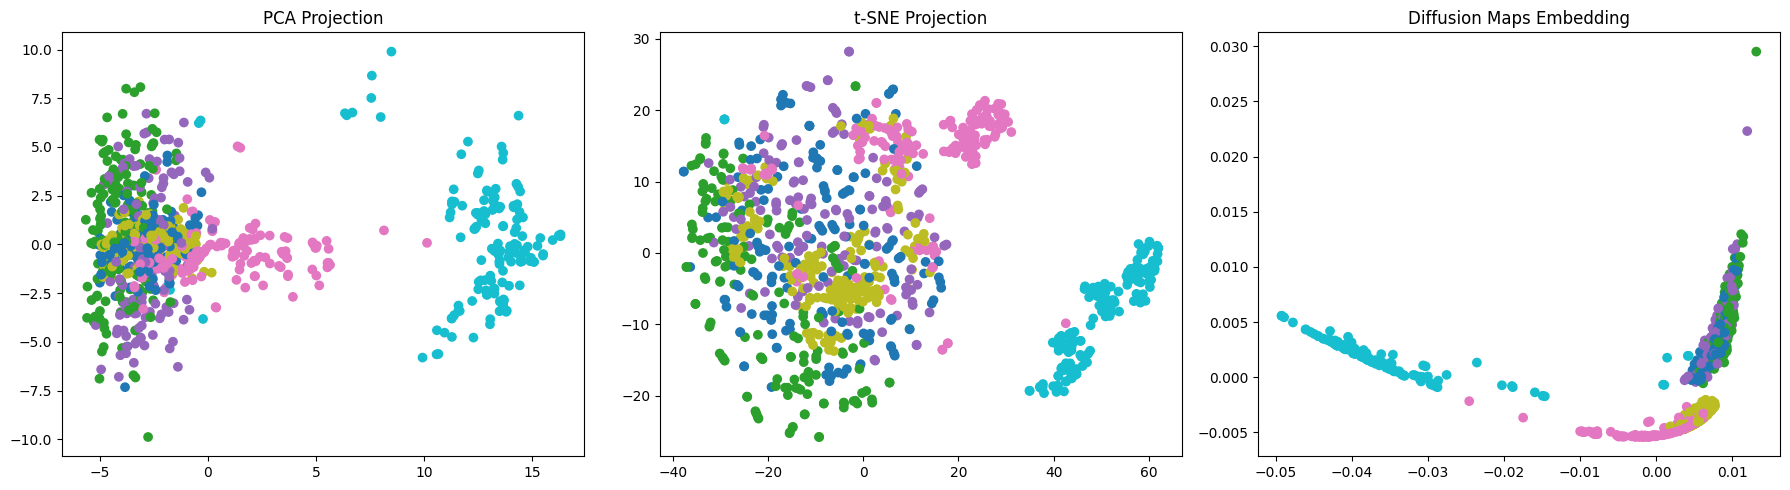

In [9]:
plt.figure(figsize=(18, 5))

# PCA Projection
plt.subplot(131)
pca = PCA(n_components=2).fit_transform(flat_data)
plt.scatter(pca[:,0], pca[:,1], c=y, cmap='tab10')
plt.title('PCA Projection')

# t-SNE Projection
plt.subplot(132)
tsne = TSNE(n_components=2).fit_transform(flat_data)
plt.scatter(tsne[:,0], tsne[:,1], c=y, cmap='tab10')
plt.title('t-SNE Projection')

plt.subplot(133)
plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='tab10')
plt.title('Diffusion Maps Embedding')
# plt.xlim(-0.08, 0.04)  # X-axis range
# plt.ylim(-0.001, 0.001)     # Y-axis range

plt.tight_layout()
plt.show()

# Compare clustering quality across embeddings


In [10]:
# Cluster and evaluate raw data
X_reshaped = X.reshape(X.shape[0], -1)  # Flatten time-step dimension
kmeans_raw = KMeans(n_clusters=6, random_state=42).fit(X_reshaped)
ari_raw = adjusted_rand_score(y, kmeans_raw.labels_)
silhouette_raw = silhouette_score(X_reshaped, kmeans_raw.labels_)


# Cluster and evaluate PCA
kmeans_pca = KMeans(n_clusters=6, random_state=42).fit(pca)
ari_pca = adjusted_rand_score(y, kmeans_pca.labels_)  # Use 500 samples
silhouette_pca = silhouette_score(pca, kmeans_pca.labels_)

# Cluster and evaluate t-SNE
kmeans_tsne = KMeans(n_clusters=6, random_state=42).fit(tsne)
ari_tsne = adjusted_rand_score(y, kmeans_tsne.labels_)  # Use 500 samples
silhouette_tsne = silhouette_score(tsne, kmeans_tsne.labels_)


print("\nClustering Performance Comparison:")
print(f"Raw Data - ARI: {ari_raw:.4f}, Silhouette: {silhouette_raw:.4f}")
print(f"PCA - ARI: {ari_pca:.4f}, Silhouette: {silhouette_pca:.4f}")
print(f"t-SNE - ARI: {ari_tsne:.4f}, Silhouette: {silhouette_tsne:.4f}")
print(f"Diffusion Maps - ARI: {adjusted_rand_score(y, clusters):.4f}, Silhouette: {silhouette_score(embedding, clusters):.4f}")


Clustering Performance Comparison:
Raw Data - ARI: 0.2411, Silhouette: 0.0597
PCA - ARI: 0.2382, Silhouette: 0.4327
t-SNE - ARI: 0.2587, Silhouette: 0.4629
Diffusion Maps - ARI: 0.4061, Silhouette: 0.5699


## Short Report:

**Choice of Distance Metric:**
- DTW is chosen because it effectively handles temporal misalignment between time-series segments. It captures meaningful similarities in human activities even when slightly shifted or varied in speed.

**Why Diffusion Maps outperform PCA/t-SNE:**
- PCA is linear and cannot capture nonlinear structures inherent in complex sensor data.
- t-SNE preserves local structure well but struggles with global structure and scalability issues with large datasets.
- Diffusion Maps leverage the underlying manifold structure of data by constructing a diffusion kernel. They effectively preserve global relationships and intrinsic geometry of data points by capturing nonlinear relationships that are crucial for complex sensor-based human activity data.

**Conclusion:**
- Diffusion Maps provide superior clustering quality due to their ability to capture intrinsic manifold structures and temporal dynamics inherent in time-series data.
